Visibilities are commonly spectrally and temporally averaged to save space. This is typically done by considering the longest baseline, which limits the extent of the averaging. This can be thought of as limiting the range of u,v coordinates that are combined into a single u,v point, since a range of frequencies or times corresponds to a shift in u,v for a given baseline.

The parameter $\beta$ is the fractional bandwidth multiplied by the baseline to antenna diameter ratio; data with shorter baselines can be averaged over a wider range of frequencies. The equations below show that at a given frequency $\Delta\nu B_{\rm max}$ needs to be constant for the same loss of response (same $\beta_{\rm max$). The same is true for time averaging, with $\Delta t B_{\rm max}$ a constant. If we look only at some shorter baselines below $B$, we can average over a greater frequency or time range. At that baseline $B$, a greater frequency/time range corresponds to a greater range in u,v that we can average over. Doubling the frequency/time range doubles the u,v range, so halving the baseline leads to the same u,v range being covered.

This is in contrast to the current methods, which sets $\Delta\nu$ and $\Delta t$ for $B_{\rm max}$, and therefore does not average shorter baselines as much as is allowable for the response that will be tolerated, i.e. the u,v bin is smaller at smaller u,v.

This is implemented with the CASA `msuvbin` task, but this is rather clumsy since it generates huge files if there are thousands of u,v bins (most of which are empty).

From `https://safe.nrao.edu/wiki/pub/Main/RadioTutorial/BandwidthSmearing.pdf` we are concerned with the reduction in peak response at some distance from the phase center (see also ERA, the results are the same but $R_{\Delta\nu}$ is not used). This might be the primary beam FOV, but could be a bit smaller for disks, e.g. ~5arcsec. The decrement is
$$ R_{\Delta\nu} = \frac{1}{\sqrt{1+\beta_{\rm max}^2} $$
where
$$ \beta_{\rm max} = \frac{\Delta\nu}{\nu} \frac{B_{\rm max}}{2\sqrt{\ln2}D} $$
and $B_{\rm max}$ is the maximum baseline and $D$ is the antenna diameter.

We set $R_{\Delta\nu}=0.99$ for a 1% decrement, and using the frequency $\nu$ and diameter $D$ figure out the allowed $\Delta\nu$. These are tabulated in the PDF at the link.

The equation for $\beta$ can be re-written differently; consider the value of $\beta$ for some baseline $B$
$$ \beta = \frac{\lambda}{2\sqrt{\ln2}D} \frac{\Delta\lambda}{\lambda} \frac{B}{\lambda} $$
to see the relation as the primary beam size multiplied by a distance in u,v space
$$ \Delta_{\rm uv} = \frac{\Delta\lambda}{\lambda} \frac{B}{\lambda} $$
so
$$ \beta = \frac{0.6 \lambda}{D} \Delta_{u,v} $$
Now we can set $R_{\Delta\nu}$ and solve for the allowed $\Delta_{\rm uv}$. At some baseline (u,v point) to satisfy $R_{\Delta\nu}$ we require a u,v bin size no larger than $\Delta\lambda/\lambda \times B/\lambda$ in size. Since $\Delta\lambda$ and $B$ are wrapped up in $\Delta_{\rm u,v}$, the u,v resolution is only set by the primary beam size, and that we are requiring some decrement at that distance from the phase center.

We could further simplfy by specifying a different distance from the phase center beyond which we are happy for the decrement to be greater than 1%, 5" radial distance for a 2au disk say, which replaces the first term.

Equivalently in time we do not want smearing, so have a similar criterion
$$ \beta_{\rm max} = \frac{2 \pi \Delta t}{P} \frac{B}{\lambda} \frac{\lambda}{2\sqrt{\ln 2}D} $$
set by rotation not moving the source at the PB edge more than some fraction of the beam width. The first term on the RHS is again a fraction of $u,v$, but now in the azimuthal direction, so equivalent to $\Delta \lambda/\lambda$ in terms of distance in the u,v plane (i.e. u,v cells are approximately square). This equation can be rewritten as for $\beta$ above (though is not strictly the same thing), so the requirement is again for a certain $\Delta_{u,v}$ given a distance from the phase center.

As long as $\Delta t << P$ then the u,v cells we are picturing are small and approximately square despite being defined in radial and azimuthal directions. We can simply picture rotating these so that we are binning in cells in the u,v directions.

## Binning

In [1]:
import numpy as np
from scipy.stats import binned_statistic, binned_statistic_2d
import matplotlib.pyplot as plt

In [2]:
# verify some of the calculations from
# https://safe.nrao.edu/wiki/pub/Main/RadioTutorial/BandwidthSmearing.pdf
c=3e8
nu = 350e9
dnu = 1000e6
wav = c/nu
dwav = c*dnu/nu**2

D = 12.0
B = 3600

duv = B/wav * dwav/wav
beta = 0.6 * wav/D * duv
Rdnu = 1/np.sqrt(1+beta**2)
wav*1e3, dwav*1e3, duv, beta, Rdnu

(0.8571428571428571,
 0.0024489795918367346,
 12000.000000000002,
 0.5142857142857142,
 0.8892878023181471)

In [3]:
def get_duv_(R, wav, D):
    return 1/0.6 * D/wav * np.sqrt(1/R**2 - 1)

def get_duv(R=0.99, size_arcsec=8.84):
    """equivalent in arcsec"""
    return 1/(size_arcsec/3600*np.pi/180) * np.sqrt(1/R**2 - 1)

get_duv_(0.99, wav, D), get_duv(size_arcsec=8.84)

(3324.8199278673756, 3324.7899396964244)

In [4]:
u_, v_, Re_, Im_, w_, wavelength, ms_files = \
    np.load('/Users/grant/astro/data/alma/arks/HD109573/visibilities/HD109573.12mSB.npy', allow_pickle=True)
vis_ = Re_ + 1j*Im_
len(u_)

65160

In [5]:
def get_chi2(Re, Im, w):
    return np.sum((Re**2.0 + Im**2.0) * w)

def get_chi2_vis(vis, w):
    return np.sum((vis*vis.conj()).real * w)

In [6]:
get_chi2(Re_, Im_, w_), get_chi2_vis(vis_, w_)

(154363.58918026488, 154363.58918026488)

In [7]:
uneg = u_<0
u_ = np.abs(u_)
v_[uneg] = -v_[uneg]
Im_[uneg] *= -1

In [8]:
get_chi2(Re_, Im_, w_), get_chi2_vis(vis_, w_)/len(u_)

(154363.58918026488, 2.3689930813423095)

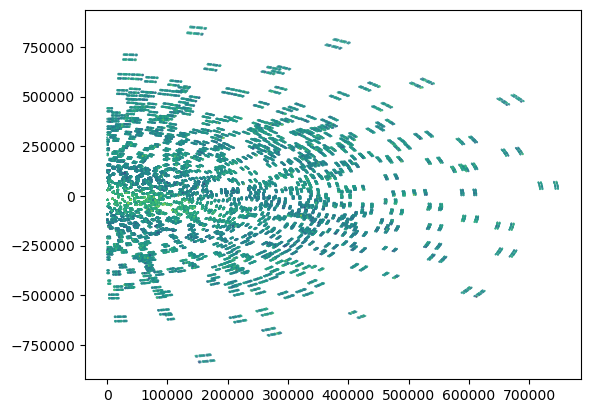

In [9]:
fig, ax = plt.subplots()
ax.scatter(u_, v_, c=Re_, s=0.1)

In [10]:
binsz = get_duv(size_arcsec=10)
print(binsz)

bins = [int(np.max(np.abs(v_))/binsz)*2, int(np.max(np.abs(u_))/binsz)]

u,  _, _, _ = binned_statistic_2d(u_, v_, u_*w_, statistic='sum', bins=bins)
v,  _, _, _ = binned_statistic_2d(u_, v_, v_*w_, statistic='sum', bins=bins)
Re, _, _, _ = binned_statistic_2d(u_, v_, Re_*w_, statistic='sum', bins=bins)
Im, _, _, _ = binned_statistic_2d(u_, v_, Im_*w_, statistic='sum', bins=bins)
vis,_, _, _ = binned_statistic_2d(u_, v_, vis_*w_, statistic='sum', bins=bins)
w,  x, y, _ = binned_statistic_2d(u_, v_, w_, statistic='sum', bins=bins)

print(w.shape, np.diff(x)[0], np.diff(y)[0])

ok = w != 0
u = (u[ok] / w[ok]).flatten()
v = (v[ok] / w[ok]).flatten()
Re = (Re[ok] / w[ok]).flatten()
Im = (Im[ok] / w[ok]).flatten()
vis = (vis[ok] / w[ok]).flatten()
w = w[ok].flatten()

2939.114306691639
(580, 254) 1288.9367413624916 6655.36836362863


In [11]:
u.shape

(15191,)

In [12]:
get_chi2(Re, Im, w), get_chi2_vis(vis, w)/len(u)

(55316.38445978388, 3.6467792622641606)

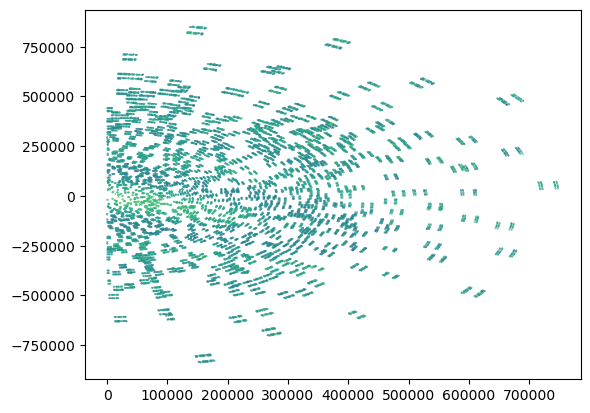

In [13]:
fig, ax = plt.subplots()
ax.scatter(u, v, c=Re, s=0.1)

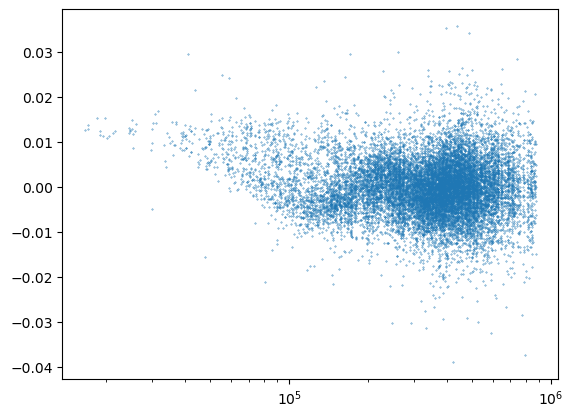

In [14]:
ruv = np.sqrt(u**2 + v**2)
fig, ax = plt.subplots()
ax.scatter(ruv, Re, s=0.1)
ax.set_xscale('log')
# ax.set_ylim(-0.01, 0.01)

## Numerical tests
Tests of what one expects given random distributions. It seems that for Gaussian noise the chi2 per d.o.f. is preserved with averaging. But when there is some signal present the chi2 changes as the data are averaged, how much the chi2 changes depends on how much signal w.r.t. the noise.

This implies that for a models that fits well the noise should average such that the reduced chi2 is the same when averaged. But some testing should be done that verifies that the parameter distributions are the same, since for the parameter distributions the models will be departing from the data somewhat.

In [15]:
s0 = 0.1
a = np.random.normal(scale=s0, size=1_000_000) + 0.001
s = np.ones_like(a) * s0
w = 1/s**2
x = np.arange(len(a))

In [16]:
np.std(a), np.mean(a)

(0.10008511857439653, 0.0010235420868311826)

In [17]:
def chi2(d, u):
    return np.sum((d/u)**2)

In [18]:
chi2(a, s)/len(a)

1.0018078598454525

In [19]:
nbin = 10000

In [20]:
a1, _, _ = binned_statistic(x, a, statistic='mean', bins=nbin)
s1, _, _ = binned_statistic(x, s, statistic=lambda x: s0/np.sqrt(len(x)), bins=nbin)

In [21]:
chi2(a1, s1)/len(a1)

1.0073444852923528

In [22]:
a2, _, _ = binned_statistic(x, a*w, statistic='sum', bins=nbin)
w2, _, _ = binned_statistic(x, w, statistic='sum', bins=nbin)
a2 /= w2

In [23]:
chi2(a2, 1/np.sqrt(w2))/len(a2)

1.0073444852923523